In [10]:
######################
## Import Libraries ##
######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from sklearn import metrics

##########################
## Import training data ##
##########################
# KKH data used for training and validation from 2007-2013
os.chdir('C:\\Users\\audre\\Desktop\\MRI Text Classification\\Datasets')
data_ACR = pd.read_csv('KKH_ACR_cleaned_v2.csv')              # label 1
data_non_ACR = pd.read_csv('KKH_non_ACR_cleaned_v2.csv')      # label 0
# Combining datasets
KKH_data = data_ACR[['No.', 'Indication for MRI', 'ACR/No ACR']].append(data_non_ACR[['No.', 'Indication for MRI', 'ACR/No ACR']], ignore_index = True)

text = []
y = []
for i in range(0, len(KKH_data)):
    sentence = KKH_data['Indication for MRI'][i]        
    sentence = re.sub('[^a-zA-Z]', ' ', str(sentence))     # replace non-alphabets with whitespace
    sentence = sentence.lower()
    text.append(sentence)
    label = KKH_data['ACR/No ACR'][i]
    y.append(label)

######################
## Import test data ##
######################
#Load new KKH data (2014-2017)
os.chdir('C:\\Users\\audre\\Desktop\\MRI Text Classification\\Datasets\\KKH_newdata(2014-2017)')
new_data = pd.read_excel('KKH_201401-201709 annonymised.xls', sheet_name = 'Export Worksheet')

# Data Cleaning 
new_data.dropna(subset = ['Follow_ACR'], how = 'any', inplace=True)    # remove NAs from the data
new_data = new_data.reset_index(drop = True)

for i in range(0, len(new_data)):
    sentence = new_data['Indication/History'][i]          
    sentence = re.sub('[^a-zA-Z]', ' ', str(sentence))       # replace non-alphabets with whitespace
    sentence = sentence.lower()                              # convert to lowercase
    text.append(sentence)
    label = new_data['Follow_ACR'][i]
    label = label.astype(int)
    y.append(label)
    
###############
## Tokenizer ##
###############
from keras.preprocessing.text import Tokenizer
import pickle
tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # ignore these characters in the text
                     lower = True,                                       # convert to lowercase
                     split = ' ')                                        # split words by space
tokenizer.fit_on_texts(text)    # build tokenizer based on specified text
word_index = tokenizer.word_index
print('Found %d unique words.' % len(word_index))

with open('tokenizer_biowordvec_v2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(text)  # convert texts to sequences (vectors of integers)

Found 5624 unique words.


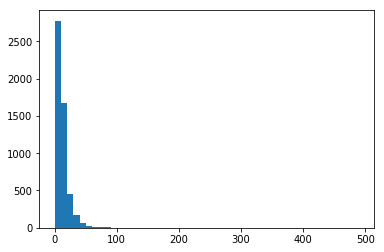

In [11]:
# Show distribution of number of words in a sentence to decide maxlen
totalNumWords = [len(i) for i in sequences]
plt.hist(totalNumWords, bins = np.arange(0, 500, 10))
plt.show()

In [13]:
################
## Preprocess ##
################
# Padding: to make the sentences equal in length
from keras.preprocessing.sequence import pad_sequences
maxlen = 90
def pad(df):
    padded_sequences = pad_sequences(df, maxlen = maxlen)
    return padded_sequences
padded = pad(sequences)    # pad sequences in training set

# One-hot encode y-values 
from keras.utils import to_categorical
# This step is not necessary if using 'sigmoid' as final activation.
encoded_train = to_categorical(y)           # encode y-values in training set

In [14]:
#############################
## Loading word embeddings ##
#############################
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('C:\\Users\\audre\\Desktop\\MRI Text Classification\\bio_embedding_extrinsic', binary = True)
word_vectors = model.wv
print('Number of word vectors: %d' % len(word_vectors.vocab))

Number of word vectors: 2324849


C:\Users\audre\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [27]:
#############################
## Create embedding matrix ##
#############################
embed_dim = 200
max_features = len(word_index) + 1
wv_matrix = np.zeros((max_features, embed_dim))    # initialize the matrix
for word, i in word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_vector = word_vectors[word]       
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass

In [28]:
####################
## Training Model ##
####################
# Simple LSTM
from keras import optimizers
from keras.layers import Dense, LSTM, Embedding, Dropout, Flatten
from keras.layers import Bidirectional, MaxPooling1D
from keras.models import Sequential
from keras.metrics import binary_accuracy

embed_size = 200

model = Sequential()
model.add(Embedding(max_features, embed_size, weights = [wv_matrix], input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(32, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(MaxPooling1D())
model.add(Flatten()) 
model.add(Dense(2, activation = 'softmax'))  
# If using sigmoid activation, replace line 13 with
# model.add(Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = optimizers.RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = [binary_accuracy])

# fit the model
batch_size = 32
lstm = model.fit(padded, encoded_train,
                 epochs = 200,
                 batch_size = batch_size)

# save the model
model.save('C:\\Users\\audre\\Desktop\\MRI Text Classification\\GUI\\biowordvec_BiLSTM_model_v2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 90, 200)           1125000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 90, 64)            59648     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 45, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 45, 64)            24832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 22, 64)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 22, 64)            24832     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 11, 64)            0         
__________

5181/5181 [==============================] - 40s 8ms/step - loss: 0.2957 - binary_accuracy: 0.8732
Epoch 61/200
5181/5181 [==============================] - 38s 7ms/step - loss: 0.2924 - binary_accuracy: 0.8786
Epoch 62/200
5181/5181 [==============================] - 41s 8ms/step - loss: 0.3049 - binary_accuracy: 0.8691
Epoch 63/200
5181/5181 [==============================] - 40s 8ms/step - loss: 0.2956 - binary_accuracy: 0.8771
Epoch 64/200
5181/5181 [==============================] - 41s 8ms/step - loss: 0.2976 - binary_accuracy: 0.8747
Epoch 65/200
5181/5181 [==============================] - 39s 8ms/step - loss: 0.2942 - binary_accuracy: 0.8798
Epoch 66/200
5181/5181 [==============================] - 40s 8ms/step - loss: 0.3007 - binary_accuracy: 0.8759
Epoch 67/200
5181/5181 [==============================] - 40s 8ms/step - loss: 0.2928 - binary_accuracy: 0.8749
Epoch 68/200
5181/5181 [==============================] - 40s 8ms/step - loss: 0.2904 - binary_accuracy: 0.8794
Epoch

5181/5181 [==============================] - 53609s 10s/step - loss: 0.2577 - binary_accuracy: 0.8933
Epoch 133/200
5181/5181 [==============================] - 45s 9ms/step - loss: 0.2556 - binary_accuracy: 0.8917
Epoch 134/200
5181/5181 [==============================] - 45s 9ms/step - loss: 0.2443 - binary_accuracy: 0.9016
Epoch 135/200
5181/5181 [==============================] - 45s 9ms/step - loss: 0.2538 - binary_accuracy: 0.8964
Epoch 136/200
5181/5181 [==============================] - 44s 9ms/step - loss: 0.2446 - binary_accuracy: 0.8985
Epoch 137/200
5181/5181 [==============================] - 43s 8ms/step - loss: 0.2474 - binary_accuracy: 0.8994
Epoch 138/200
5181/5181 [==============================] - 41s 8ms/step - loss: 0.2527 - binary_accuracy: 0.8965
Epoch 139/200
5181/5181 [==============================] - 40s 8ms/step - loss: 0.2560 - binary_accuracy: 0.8977
Epoch 140/200
5181/5181 [==============================] - 44s 8ms/step - loss: 0.2475 - binary_accuracy: 0

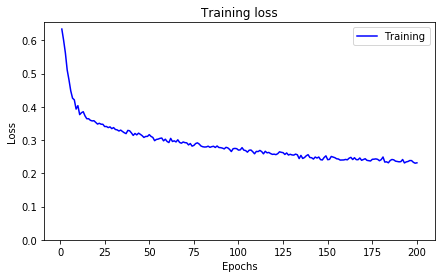

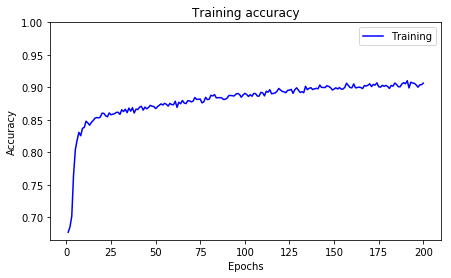

In [29]:
# plot losses
plt.figure(figsize = (7, 4))
ax = plt.subplot(111)                      # 111 means 1x1 grid, first subplot
train_loss = lstm.history['loss']          # retrieve training loss values
epochs = range(1, len(train_loss) + 1)
ax.plot(epochs, train_loss, 'b', label = 'Training')      # b means blue line
plt.ylim(bottom = 0)
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
ax.legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

# plot accuracy
plt.figure(figsize = (7, 4))
ax = plt.subplot(111)                               # 111 means 1x1 grid, first subplot
train_acc = lstm.history['binary_accuracy']         # retrieve training accuracy values
epochs = range(1, len(train_acc) + 1)
ax.plot(epochs, train_acc, 'b', label = 'Training')      # b means blue line        
plt.ylim(top = 1)
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
ax.legend(bbox_to_anchor = (1.0, 1.0))
plt.show()

# If the loss increases and the accuracy increase too is because 
# your regularization techniques are working well and you're fighting the overfitting problem. 
# This is true only if the loss, then, starts to decrease whilst the accuracy continues to increase. 
# Otherwise, if the loss keep growing your model is diverging 
# and you should look for the cause (usually you're using a too high learning rate value).

In [30]:
# Predict 
import warnings
warnings.filterwarnings('ignore')

y_prob_lstm = model.predict(padded)    # predict probability of each validation set instance belonging to label 0 and 1
prob_1_val = []                         # create list to store all probabilities that instance is label 1
for i in y_prob_lstm:
    pred = i[1]                         # get the probability that the instance is label 1
    prob_1_val.append(pred)
y_pred_lstm = model.predict_classes(padded)   # predict the label of each validation set instance

# Metrics
print('Performance metrics - Training set')
print('Accuracy: ', metrics.accuracy_score(y, y_pred_lstm))                   # accuracy
print('ROC-AUC score: ', metrics.roc_auc_score(y, prob_1_val))                # ROC-AUC score
cm_lstm = metrics.confusion_matrix(y, y_pred_lstm)                            # create confusion matrix
print('Confusion matrix: \n', cm_lstm)                                            # confusion Matrix
print('Specificity: ', cm_lstm[0,0]/(cm_lstm[0,0] + cm_lstm[0,1]))                # specificity
print('Precision: ', cm_lstm[1,1]/(cm_lstm[0,1] + cm_lstm[1,1]))                  # precision
print('Recall: ', cm_lstm[1,1]/(cm_lstm[1,0] + cm_lstm[1,1]))                     # recall
print('F1 score: ', metrics.f1_score(y, y_pred_lstm, average='binary'), '\n') # F1 Score

Performance metrics - Training set
Accuracy:  0.9187415556842309
ROC-AUC score:  0.9719659558251426
Confusion matrix: 
 [[1384  249]
 [ 172 3376]]
Specificity:  0.8475199020208206
Precision:  0.9313103448275862
Recall:  0.95152198421646
F1 score:  0.9413076815837167 

